# Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack, csr_matrix
import shap
from collections import Counter
import lime
import lime.lime_tabular
from imblearn.over_sampling import SMOTE
import warnings
import joblib
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("yelp_dataset_after_finalization.csv")

df.head()

,business_name,review_id,user_id,date,stars_review,stars_business_average,normalized_text,lemmatized_ml,lemmatized_dl,lemmatized_bert,sentiment_label,daily_spike_score,hourly_spike_score,is_fake,max_similarity_score,most_similar_review_id
0,Acme Oyster House,qdpoNaAd2d8hz354jRKryg,M2jgPvf6syoOHGW0R8PotQ,2012-02-07 00:05:19,2,4,I grew upon seafood corn meal breaded seafood ...,"['grow', 'upon', 'seafood', 'corn', 'meal', 'b...","['grow', 'upon', 'seafood', 'corn', 'meal', 'b...","['i', 'grow', 'upon', 'seafood', 'corn', 'meal...",negative,0.000000,3.592276,0,0.264060,TiRy733reHgq5v9_ePcJSA
1,Acme Oyster House,5t14YNj5mji1aoIbt3uoQQ,akv8uZ1X6POqCWXYcnbXfA,2015-02-24 01:49:26,4,4,The Acme is a long time favorite At the age of...,"['acme', 'long', 'time', 'favorite', 'age', 'd...","['acme', 'long', 'time', 'favorite', 'age', 'd...","['the', 'acme', 'be', 'a', 'long', 'time', 'fa...",positive,1.251283,3.592276,1,0.259275,3futyMTxE8viSKTBdkM03g
2,Acme Oyster House,b2lwJxRgseknM_0B5cRkFQ,2zhTsvYOEPQaQP9w53zkvA,2010-01-07 18:09:30,2,4,A tourist site with the soul of a TGI Friday s...,"['tourist', 'site', 'soul', 'tgi', 'friday', '...","['tourist', 'site', 'soul', 'tgi', 'friday', '...","['a', 'tourist', 'site', 'with', 'the', 'soul'...",negative,0.546965,3.592276,1,0.234411,h6h7cvApI6aIV9Wdg__pPQ
3,Acme Oyster House,_BAe5c9nCJh7ntBo2YMqsQ,eZGoPMRfq2hw5LfwJg0uTA,2010-01-07 18:12:23,3,4,The wife and I had dinner there in January We ...,"['wife', 'dinner', 'january', 'go', 'early', '...","['wife', 'dinner', 'january', 'go', 'early', '...","['the', 'wife', 'and', 'i', 'have', 'dinner', ...",positive,0.546965,3.592276,1,0.260815,yKLuUKdwcvtGCBYuBi3X4A
4,Acme Oyster House,rFeHUzOELJlba9vHxvR6Ug,uBvrdhNSlGnN35NA8cSMwQ,2010-01-11 02:27:03,4,4,Based on the Yelp reviews I stopped by Acme Oy...,"['base', 'yelp', 'review', 'stop', 'acme', 'ho...","['base', 'yelp', 'review', 'stop', 'acme', 'ho...","['base', 'on', 'the', 'yelp', 'review', 'i', '...",positive,0.546965,3.592276,1,0.320177,7BBjoF6ihpS9s6f3F0iajQ


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_name           7670 non-null   object 
 1   review_id               7670 non-null   object 
 2   user_id                 7670 non-null   object 
 3   date                    7670 non-null   object 
 4   stars_review            7670 non-null   int64  
 5   stars_business_average  7670 non-null   int64  
 6   normalized_text         7670 non-null   object 
 7   lemmatized_ml           7670 non-null   object 
 8   lemmatized_dl           7670 non-null   object 
 9   lemmatized_bert         7670 non-null   object 
 10  sentiment_label         7670 non-null   object 
 11  daily_spike_score       7670 non-null   float64
 12  hourly_spike_score      7670 non-null   float64
 13  is_fake                 7670 non-null   int64  
 14  max_similarity_score    7670 non-null   

# Analyze Imbalance Data

Class Distribution:
is_fake
0    6771
1     899
Name: count, dtype: int64


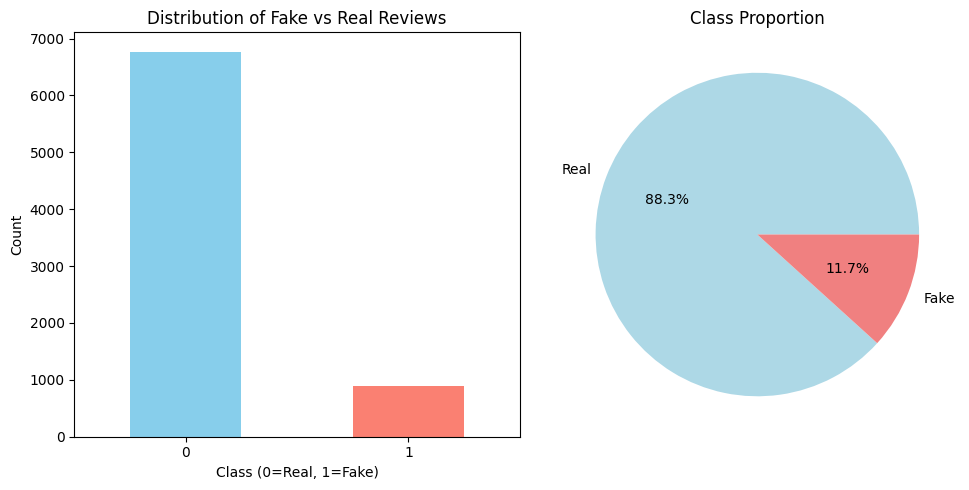


Imbalance Ratio (Real:Fake): 7.53:1


In [7]:
class_distribution = df['is_fake'].value_counts()
print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Fake vs Real Reviews')
plt.xlabel('Class (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_distribution.values, labels=['Real', 'Fake'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

# Hitung imbalance ratio
imbalance_ratio = class_distribution[0] / class_distribution[1]
print(f"\nImbalance Ratio (Real:Fake): {imbalance_ratio:.2f}:1")

# PREPROCESS TEXT DATA

In [8]:
# Konversi lemmatized_ml dari list of tokens ke string
def tokens_to_string(tokens):
    if isinstance(tokens, list):
        return ' '.join(tokens)
    elif isinstance(tokens, str):
        # Jika sudah string, coba evaluasi sebagai list
        try:
            tokens_list = eval(tokens)
            if isinstance(tokens_list, list):
                return ' '.join(tokens_list)
        except:
            return str(tokens)
    return str(tokens)

print("Mengkonversi lemmatized_ml tokens ke string...")
df['lemmatized_ml_text'] = df['lemmatized_ml'].apply(tokens_to_string)

# Cek hasil konversi
print("\nContoh data setelah konversi:")
print("Original lemmatized_ml:", df['lemmatized_ml'].iloc[0])
print("Converted text:", df['lemmatized_ml_text'].iloc[0][:300])

Mengkonversi lemmatized_ml tokens ke string...

Contoh data setelah konversi:
Original lemmatized_ml: ['grow', 'upon', 'seafood', 'corn', 'meal', 'bread', 'seafood', 'deep', 'fry', 'restaurant', 'exactly', 'advertise', 'excellent', 'cooked', 'one', 'superb', 'menu', 'deep', 'fry', 'seafood', 'experience', 'go', 'know', 'get', 'long', 'line', 'touristy', 'extremely', 'popular']
Converted text: grow upon seafood corn meal bread seafood deep fry restaurant exactly advertise excellent cooked one superb menu deep fry seafood experience go know get long line touristy extremely popular


# Split

In [9]:
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['is_fake'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['is_fake'],
    random_state=42
)

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


print(f"\nTraining set class distribution:")
print(train_df['is_fake'].value_counts())
print(f"\nValidation set class distribution:")
print(val_df['is_fake'].value_counts())
print(f"\nTest set class distribution:")
print(test_df['is_fake'].value_counts())

Training set: 5369 samples (70.0%)
Validation set: 1150 samples (15.0%)
Test set: 1151 samples (15.0%)

Training set class distribution:
is_fake
0    4740
1     629
Name: count, dtype: int64

Validation set class distribution:
is_fake
0    1015
1     135
Name: count, dtype: int64

Test set class distribution:
is_fake
0    1016
1     135
Name: count, dtype: int64


# PREPARE FEATURES

In [10]:
# Prepare text data dari lemmatized_ml
X_train_text = train_df['lemmatized_ml_text'].fillna('').astype(str)
X_val_text = val_df['lemmatized_ml_text'].fillna('').astype(str)
X_test_text = test_df['lemmatized_ml_text'].fillna('').astype(str)

# Prepare numerical features
numerical_features = ['stars_review', 'daily_spike_score', 'hourly_spike_score', 'max_similarity_score']
print(f"Numerical features: {numerical_features}")

X_train_numerical = train_df[numerical_features].fillna(0)
X_val_numerical = val_df[numerical_features].fillna(0)
X_test_numerical = test_df[numerical_features].fillna(0)

print(f"\nNumerical features shape:")
print(f"Training: {X_train_numerical.shape}")
print(f"Validation: {X_val_numerical.shape}")
print(f"Test: {X_test_numerical.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_val_numerical_scaled = scaler.transform(X_val_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Target variables
y_train = train_df['is_fake']
y_val = val_df['is_fake']
y_test = test_df['is_fake']

Numerical features: ['stars_review', 'daily_spike_score', 'hourly_spike_score', 'max_similarity_score']

Numerical features shape:
Training: (5369, 4)
Validation: (1150, 4)
Test: (1151, 4)


# TF-IDF Feature Extraction

In [11]:
print("Contoh teks training dari lemmatized_ml:")
print(X_train_text.iloc[0][:200] + "...")

Contoh teks training dari lemmatized_ml:
longtime fan acme make point go every time new orleans today experience disappoint stellar always raw today etouffee good rich creamy jambalaya extremely salty leave much desire gumbo alright unremark...


In [12]:
# TF-IDF dengan SublinearTF dan N-gram PADA LEMMATIZED TEXT
print("\nMembuat TF-IDF Vectorizer dengan SublinearTF dan N-gram pada lemmatized text...")
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    ngram_range=(1, 3),
    max_features=8000,
    min_df=2,
    max_df=0.95,
    stop_words='english'
)


# Fit dan transform pada training data
print("Fitting TF-IDF pada lemmatized training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(f"TF-IDF dimensions - Training: {X_train_tfidf.shape}")


Membuat TF-IDF Vectorizer dengan SublinearTF dan N-gram pada lemmatized text...
Fitting TF-IDF pada lemmatized training data...
TF-IDF dimensions - Training: (5369, 8000)


# COMBINE TEXT AND NUMERICAL FEATURES

In [13]:
# Combine TF-IDF dengan numerical features
X_train_combined = hstack([X_train_tfidf, X_train_numerical_scaled])
X_val_combined = hstack([X_val_tfidf, X_val_numerical_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_numerical_scaled])

# Konversi ke CSR format untuk mendukung indexing
X_train_combined = csr_matrix(X_train_combined)
X_val_combined = csr_matrix(X_val_combined)
X_test_combined = csr_matrix(X_test_combined)

print(f"Combined features dimensions - Training: {X_train_combined.shape}")

Combined features dimensions - Training: (5369, 8004)


# SMOTE

In [14]:
print("Before SMOTE:")
print(f"Class distribution: {Counter(y_train)}")

# Apply SMOTE pada combined features
smote = SMOTE(random_state=42)
X_train_combined_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

print("After SMOTE:")
print(f"Class distribution: {Counter(y_train_resampled)}")

Before SMOTE:
Class distribution: Counter({0: 4740, 1: 629})
After SMOTE:
Class distribution: Counter({0: 4740, 1: 4740})


# Train LightGBM Model

In [16]:
param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.1, 1]
}

In [17]:
# Use stratified k-fold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_combined_resampled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_lgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'learning_rate': 1, 'max_depth': 6}
Best cross-validation score: 0.9900


# Evaluation

In [18]:
y_test_pred = best_lgb_model .predict(X_test_combined)

print("\nTEST SET PERFORMANCE Sublinear TF Fake/Real XGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Real', 'Fake']))


TEST SET PERFORMANCE Sublinear TF Fake/Real XGBoost:
Accuracy: 0.9053
F1-Score: 0.6785

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.91      0.94      1016
        Fake       0.56      0.85      0.68       135

    accuracy                           0.91      1151
   macro avg       0.77      0.88      0.81      1151
weighted avg       0.93      0.91      0.91      1151



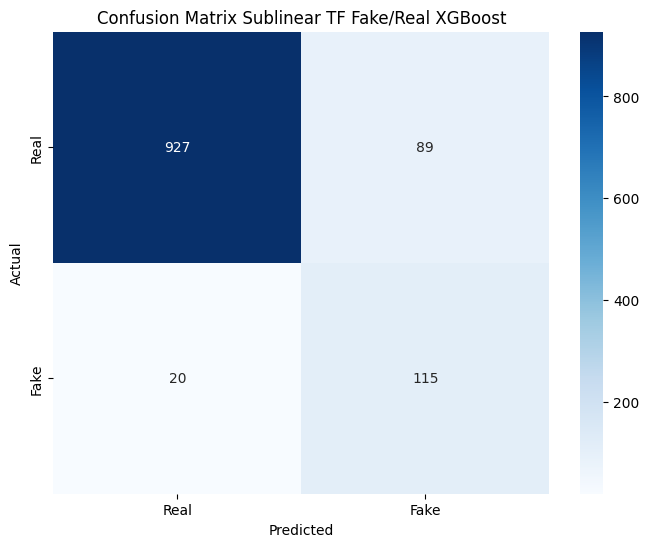

In [19]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix Sublinear TF Fake/Real XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SHAP

Menggunakan 100 samples untuk SHAP analysis...
Menghitung SHAP values...


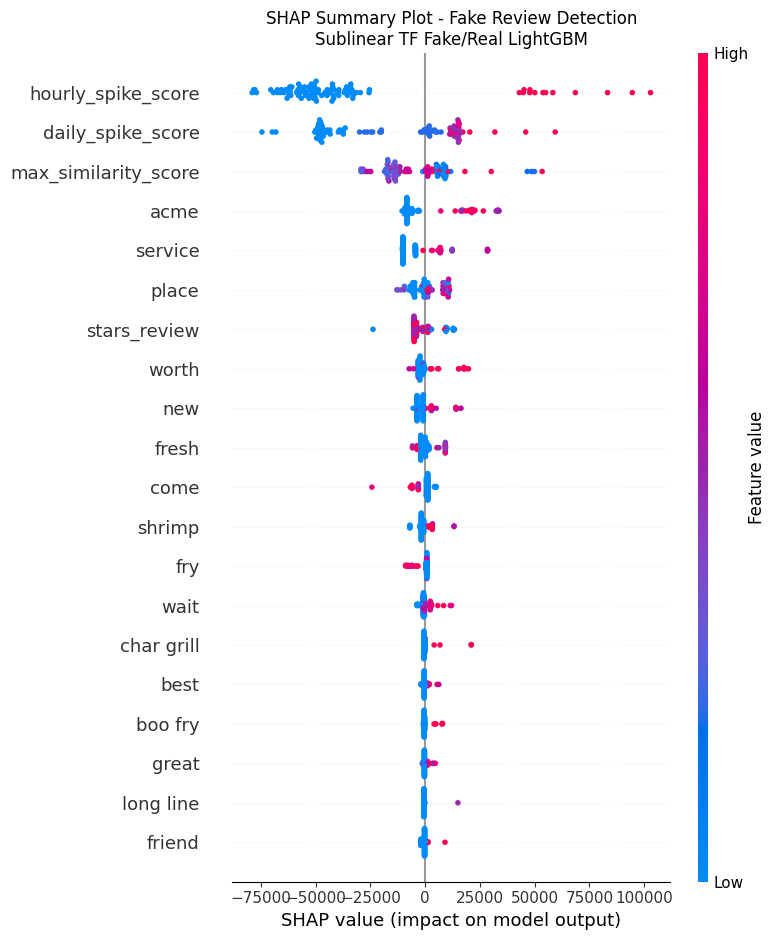

In [21]:
sample_size = min(100, X_test_combined.shape[0])
X_test_sample = X_test_combined[:sample_size]

# Buat feature names untuk combined features
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + numerical_features

print(f"Menggunakan {sample_size} samples untuk SHAP analysis...")

# Convert sparse matrix to dense untuk SHAP
X_test_sample_dense = X_test_sample.toarray()

# Create SHAP explainer untuk LightGBM
explainer = shap.TreeExplainer(best_lgb_model)

# Calculate SHAP values
print("Menghitung SHAP values...")
shap_values = explainer.shap_values(X_test_sample_dense)

# Untuk LightGBM, shap_values adalah list dengan dua elemen: [shap_values_class_0, shap_values_class_1]
if isinstance(shap_values, list):
    shap_values_fake = shap_values[1]  # Class 1 (Fake)
else:
    shap_values_fake = shap_values

# Plot SHAP summary untuk semua fitur
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_fake, X_test_sample_dense,
                  feature_names=feature_names,
                  show=False, max_display=20)
plt.title("SHAP Summary Plot - Fake Review Detection\nSublinear TF Fake/Real LightGBM")
plt.tight_layout()
plt.show()


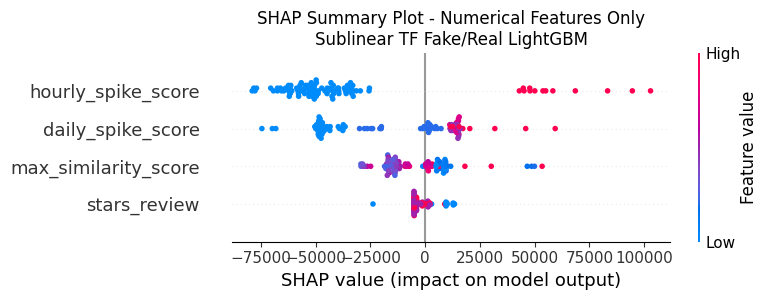

In [22]:
# SHAP summary untuk numerical features saja
numerical_indices = [len(feature_names) - len(numerical_features) + i for i in range(len(numerical_features))]
shap_values_numerical = shap_values_fake[:, numerical_indices]

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_numerical, X_test_sample_dense[:, numerical_indices],
                  feature_names=numerical_features,
                  show=False)
plt.title("SHAP Summary Plot - Numerical Features Only\nSublinear TF Fake/Real LightGBM")
plt.tight_layout()
plt.show()

In [23]:
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_fake).mean(0)
})
shap_df = shap_df.sort_values('importance', ascending=False)

print("\nTop 20 Features by SHAP Importance:")
print(shap_df.head(20))

print("\nTop Numerical Features by SHAP Importance:")
numerical_shap = shap_df[shap_df['feature'].isin(numerical_features)]
print(numerical_shap)


Top 20 Features by SHAP Importance:
                   feature    importance
8002    hourly_spike_score  52040.505373
8001     daily_spike_score  28308.470379
8003  max_similarity_score  13400.867813
34                    acme  11455.984720
6360               service   9250.502331
5099                 place   4980.277824
8000          stars_review   4943.645614
7896                 worth   3387.286230
4465                   new   3165.316284
2441                 fresh   2174.223553
1159                  come   2094.986380
6481                shrimp   2074.746428
2564                   fry   1572.769997
7589                  wait   1457.892487
1002            char grill    914.598646
555                   best    782.423515
702                boo fry    770.679815
2954                 great    731.944331
3989             long line    684.747453
2519                friend    632.926371

Top Numerical Features by SHAP Importance:
                   feature    importance
8002    hourly_sp

# LIME

Memilih contoh untuk interpretasi LIME...

--- Contoh 1 ---
Original Text: Life changing I had heard about Acme Oyster House and it was beyond my expectations We stood in line for about minutes waiting to get inside I would stand out there for hours if needed The char grille...
Lemmatized Text: life change hear acme house beyond expectation stand line minute wait get inside would stand hour need char grill blew mind also cup gumbo order raw one best meal ever dessert pecan cobbler basically ...
Actual: Fake
Predicted: Fake
Prediction Probability: Fake=1.0000, Real=0.0000

LIME Explanation:

Explanation untuk prediksi: Fake


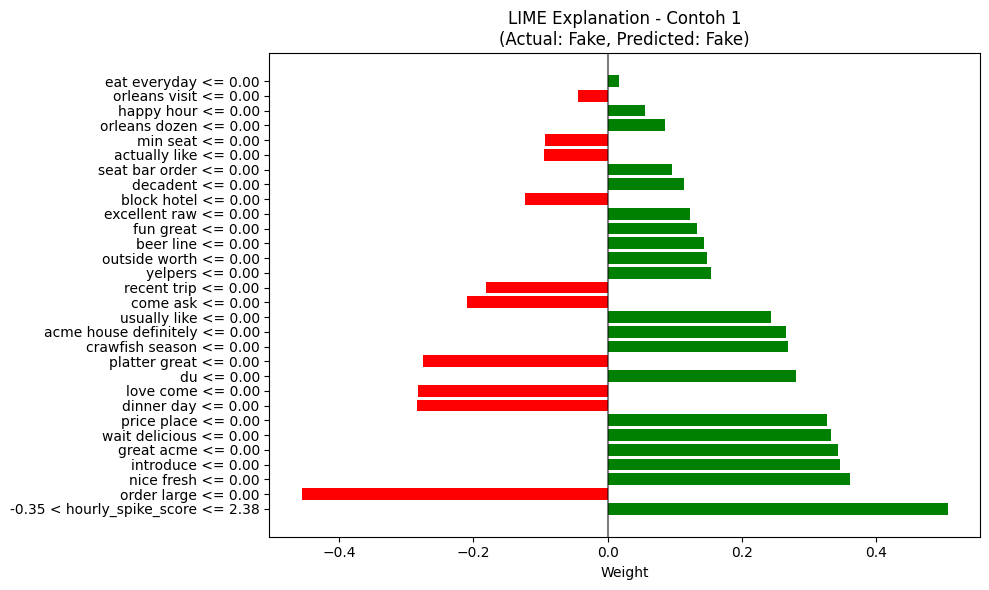


Top Features yang Mempengaruhi Prediksi:
  -0.35 < hourly_spike_score <= 2.38: 0.5066 (MENDORONG Fake)
  order large <= 0.00: -0.4554 (MENDORONG Real)
  nice fresh <= 0.00: 0.3606 (MENDORONG Fake)
  introduce <= 0.00: 0.3469 (MENDORONG Fake)
  great acme <= 0.00: 0.3430 (MENDORONG Fake)
  wait delicious <= 0.00: 0.3322 (MENDORONG Fake)
  price place <= 0.00: 0.3273 (MENDORONG Fake)
  dinner day <= 0.00: -0.2838 (MENDORONG Real)
  love come <= 0.00: -0.2826 (MENDORONG Real)
  du <= 0.00: 0.2803 (MENDORONG Fake)
  platter great <= 0.00: -0.2744 (MENDORONG Real)
  crawfish season <= 0.00: 0.2681 (MENDORONG Fake)
  acme house definitely <= 0.00: 0.2653 (MENDORONG Fake)
  usually like <= 0.00: 0.2431 (MENDORONG Fake)
  come ask <= 0.00: -0.2093 (MENDORONG Real)
  recent trip <= 0.00: -0.1804 (MENDORONG Real)
  yelpers <= 0.00: 0.1539 (MENDORONG Fake)
  outside worth <= 0.00: 0.1480 (MENDORONG Fake)
  beer line <= 0.00: 0.1443 (MENDORONG Fake)
  fun great <= 0.00: 0.1328 (MENDORONG Fake)
  

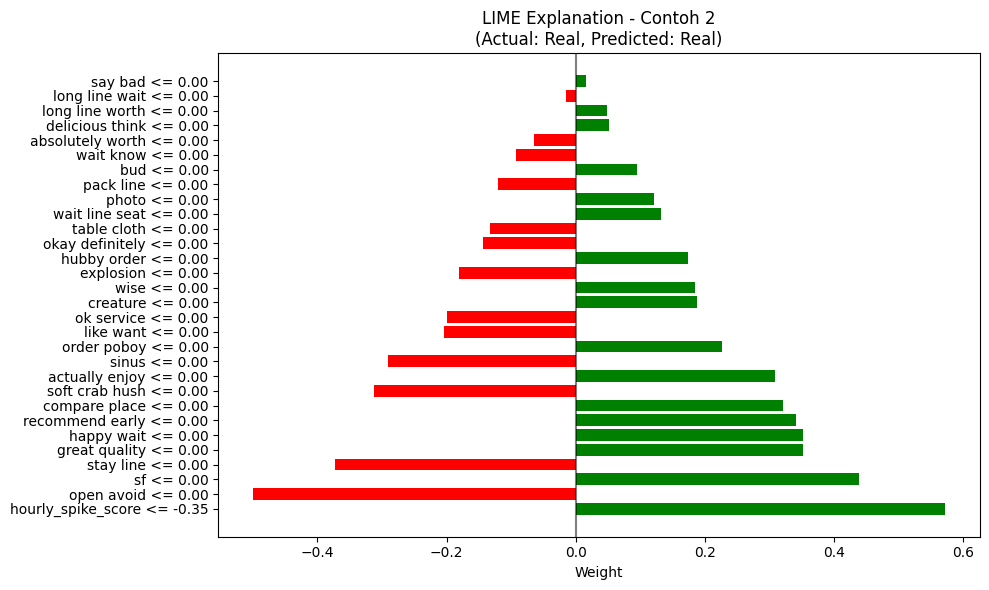


Top Features yang Mempengaruhi Prediksi:
  hourly_spike_score <= -0.35: 0.5720 (MENDORONG Real)
  open avoid <= 0.00: -0.4998 (MENDORONG Fake)
  sf <= 0.00: 0.4390 (MENDORONG Real)
  stay line <= 0.00: -0.3727 (MENDORONG Fake)
  great quality <= 0.00: 0.3514 (MENDORONG Real)
  happy wait <= 0.00: 0.3513 (MENDORONG Real)
  recommend early <= 0.00: 0.3410 (MENDORONG Real)
  compare place <= 0.00: 0.3204 (MENDORONG Real)
  soft crab hush <= 0.00: -0.3117 (MENDORONG Fake)
  actually enjoy <= 0.00: 0.3079 (MENDORONG Real)
  sinus <= 0.00: -0.2902 (MENDORONG Fake)
  order poboy <= 0.00: 0.2259 (MENDORONG Real)
  like want <= 0.00: -0.2035 (MENDORONG Fake)
  ok service <= 0.00: -0.2000 (MENDORONG Fake)
  creature <= 0.00: 0.1878 (MENDORONG Real)
  wise <= 0.00: 0.1851 (MENDORONG Real)
  explosion <= 0.00: -0.1808 (MENDORONG Fake)
  hubby order <= 0.00: 0.1737 (MENDORONG Real)
  okay definitely <= 0.00: -0.1442 (MENDORONG Fake)
  table cloth <= 0.00: -0.1332 (MENDORONG Fake)
  wait line seat 

In [24]:
training_sample = X_train_combined_resampled[:].toarray()

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=training_sample,
    feature_names=feature_names,
    class_names=['Real', 'Fake'],
    mode='classification',
    random_state=42
)

# Pilih beberapa contoh untuk dijelaskan
print("Memilih contoh untuk interpretasi LIME...")

# Cari contoh yang diprediksi sebagai Fake dan Real
y_test_proba = best_lgb_model.predict_proba(X_test_combined)
y_test_pred = best_lgb_model.predict(X_test_combined)

# Contoh Fake yang diprediksi dengan confidence tinggi
fake_indices = np.where((y_test == 1) & (y_test_proba[:, 1] > 0.7))[0]
# Contoh Real yang diprediksi dengan confidence tinggi  
real_indices = np.where((y_test == 0) & (y_test_proba[:, 0] > 0.7))[0]

examples_to_explain = []
if len(fake_indices) > 0:
    examples_to_explain.append(fake_indices[0])
if len(real_indices) > 0:
    examples_to_explain.append(real_indices[0])

if len(examples_to_explain) == 0:
    examples_to_explain = [0, 1]  # Fallback ke contoh pertama

for i, example_idx in enumerate(examples_to_explain[:2]):  # Jelaskan 2 contoh pertama
    print(f"\n--- Contoh {i+1} ---")
    
    # Get instance untuk dijelaskan
    instance = X_test_combined[example_idx].toarray().reshape(1, -1)[0]
    true_label = y_test.iloc[example_idx]
    predicted_label = y_test_pred[example_idx]
    predicted_proba = y_test_proba[example_idx]
    
    # Dapatkan teks asli
    original_text = test_df.iloc[example_idx]['normalized_text']
    lemmatized_text = test_df.iloc[example_idx]['lemmatized_ml_text']
    
    print(f"Original Text: {original_text[:200]}...")
    print(f"Lemmatized Text: {lemmatized_text[:200]}...")
    print(f"Actual: {'Fake' if true_label == 1 else 'Real'}")
    print(f"Predicted: {'Fake' if predicted_label == 1 else 'Real'}")
    print(f"Prediction Probability: Fake={predicted_proba[1]:.4f}, Real={predicted_proba[0]:.4f}")
    
    # LIME explanation - PERBAIKAN: Tentukan label yang akan dijelaskan
    print("\nLIME Explanation:")
    
    # Tentukan label berdasarkan prediksi
    label_to_explain = predicted_label
    
    exp = explainer_lime.explain_instance(
        instance, 
        best_lgb_model.predict_proba, 
        num_features=30,
        top_labels=2  # Tampilkan kedua label
    )
    
    # Tampilkan explanation di notebook
    print(f"\nExplanation untuk prediksi: {'Fake' if label_to_explain == 1 else 'Real'}")
    
    # Coba tampilkan dengan cara yang lebih aman
    try:
        # Tampilkan explanation sebagai list
        explanation_list = exp.as_list(label=label_to_explain)
        
        # Buat plot manual untuk menghindari error
        plt.figure(figsize=(10, 6))
        
        # Ambil features dan weights
        features = [x[0] for x in explanation_list[:30]]  # Top 30 features
        weights = [x[1] for x in explanation_list[:30]]
        
        # PERBAIKAN: Warna berdasarkan interpretasi yang benar
        # Untuk label yang dijelaskan (label_to_explain):
        # - weight > 0 -> mendukung label_to_explain (Hijau)
        # - weight < 0 -> mendukung label lawan (Merah)
        colors = ['green' if x > 0 else 'red' for x in weights]
        
        # Buat horizontal bar plot
        y_pos = np.arange(len(features))
        plt.barh(y_pos, weights, color=colors)
        plt.yticks(y_pos, features)
        plt.xlabel('Weight')
        plt.title(f"LIME Explanation - Contoh {i+1}\n(Actual: {'Fake' if true_label == 1 else 'Real'}, Predicted: {'Fake' if predicted_label == 1 else 'Real'})")
        
        # Tambah garis vertikal di 0
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error dalam menampilkan plot LIME: {e}")
        # Fallback: tampilkan sebagai text saja
        print("\nTop Features yang Mempengaruhi Prediksi (Text Only):")
        for feature, weight in explanation_list[:30]:
            # PERBAIKAN: Interpretasi yang benar berdasarkan label_to_explain
            if weight > 0:
                # Weight positif mendukung label yang sedang dijelaskan
                influence = f"MENDORONG {'Fake' if label_to_explain == 1 else 'Real'}"
            else:
                # Weight negatif mendukung label lawan
                influence = f"MENDORONG {'Real' if label_to_explain == 1 else 'Fake'}"
            print(f"  {feature}: {weight:.4f} ({influence})")
        continue
    
    # Tampilkan fitur yang paling berpengaruh dengan interpretasi yang benar
    print("\nTop Features yang Mempengaruhi Prediksi:")
    for feature, weight in explanation_list[:30]:
        # PERBAIKAN: Interpretasi yang benar berdasarkan label_to_explain
        if weight > 0:
            # Weight positif mendukung label yang sedang dijelaskan
            influence = f"MENDORONG {'Fake' if label_to_explain == 1 else 'Real'}"
        else:
            # Weight negatif mendukung label lawan
            influence = f"MENDORONG {'Real' if label_to_explain == 1 else 'Fake'}"
        print(f"  {feature}: {weight:.4f} ({influence})")

# Save Model

In [25]:
model_artifacts = {
    'model': best_lgb_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'scaler': scaler,
    'feature_names': feature_names,
    'numerical_features': numerical_features
}

joblib.dump(model_artifacts, 'SublinearTF_FakeReal_LightGBM.pkl')

['SublinearTF_FakeReal_LightGBM.pkl']